Computation of the upper bound to the structured singular value of a closed loop control system with uncertain plant. The controller is computed via H_infinity for suitable performance weights. This assesses robust stability for a control system designed for nominal performance. This is not a robust performance problem.
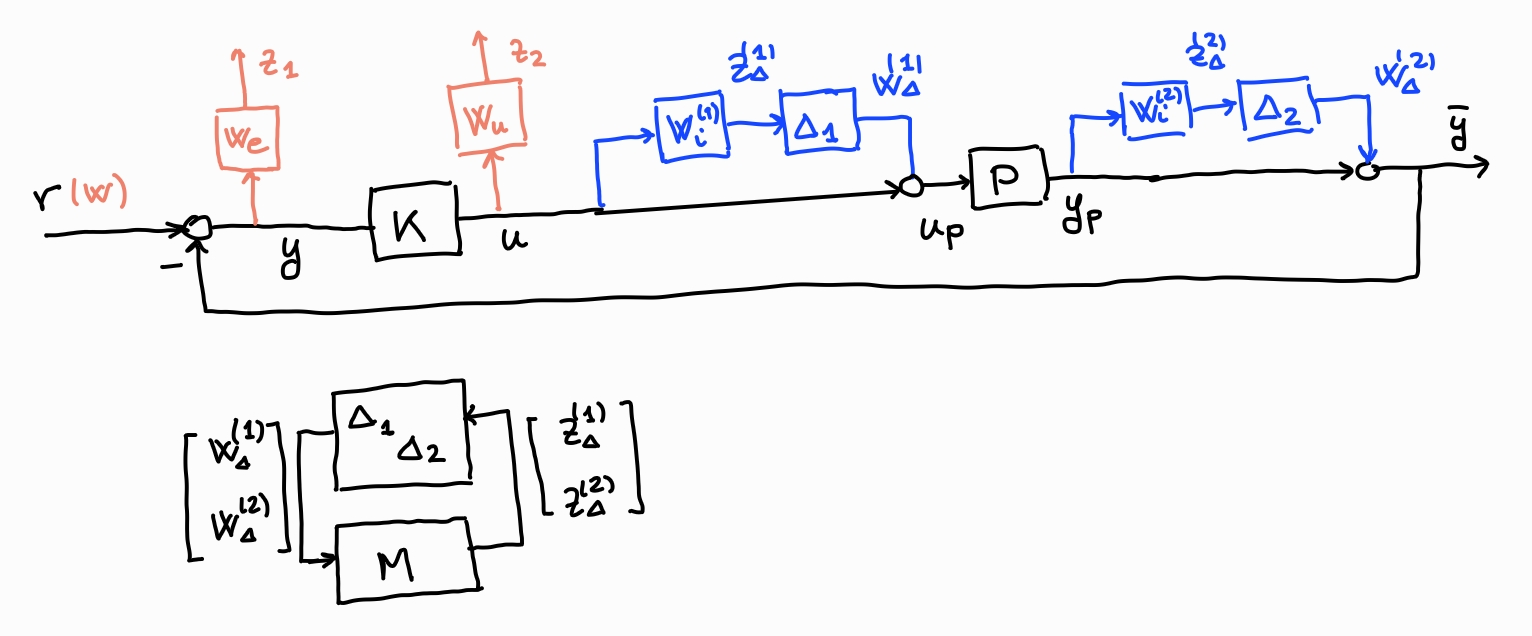

Plant uncertainty model is $P_p=(I+\Delta W_{i,2})P(I+\Delta W_{i,1})$, with $W_{i,1}=w_{i,1} I$, $W_{i,2}=w_{i,2} I$.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from itertools import product
import slycot as sly
import numpy as np
import control as ct
import rpc_diism.robust as rb

Plant

In [2]:
den = [0.2, 1.2, 1]
P = ct.tf([[[1], [1]],
              [[2, 1], [2]]],
             [[den, den],
              [den, den]])
display("Plant transfer function", P)

'Plant transfer function'

TransferFunction(
[[array([1]), array([1])],
 [array([2, 1]), array([2])]],
[[array([0.2, 1.2, 1. ]), array([0.2, 1.2, 1. ])],
 [array([0.2, 1.2, 1. ]), array([0.2, 1.2, 1. ])]],
outputs=2, inputs=2)

Define uncertainty block weights 

In [3]:
 # Uncertainty block weight Wi1
Mi = 1
ei = 1e-4
wbi = 2
Wi_1 = ct.ss(rb.weightU(wbi, Mi, ei, 1))
Wi1 = Wi_1.append(Wi_1) 

# Uncertainty block weight Wi2
Mi = 2
ei = 1e-4
wbi = 1
Wi_1 = ct.ss(rb.weightU(wbi, Mi, ei, 1))
Wi2 = Wi_1.append(Wi_1) 

Compute a controller for nominal performance via a mixed sensitivity problem

In [4]:
# Weight on S
M = 1.5
e = 1e-4
wb = 0.25
We11_1 = ct.ss(rb.weightS(wb, M, e, 1))
We = We11_1.append(We11_1) 

# Weight on KS
Mu = 1.5
eu = 1e-4
wbc = 1
Wu11_3 = ct.ss(rb.weightU(wbc, Mu, eu, 1))
Wu = Wu11_3.append(Wu11_3)

# Do mixed sensitivity design and compute the achieved closed loop inf norm gamma
K, _, info = ct.mixsyn(P, We, Wu)

Compute M block for $\mu$ analysis of the closed loop

In [5]:
# Assign labels to blocks
K.input_labels = ['y[0]','y[1]']
K.output_labels = ['u[0]','u[1]'] 
Wi1.input_labels = ['u[0]', 'u[1]']
Wi1.output_labels = ['zdelta1[0]', 'zdelta1[1]']
Wi2.input_labels = ['yp[0]', 'yp[1]']
Wi2.output_labels = ['zdelta2[0]', 'zdelta2[1]']
P.input_labels = ['up[0]','up[1]']
P.output_labels = ['yp[0]','yp[1]']

# Summing junctions from uncertain blocks
sumdelta1 = ct.summing_junction(inputs=['u','wdelta1'], output='up', dimension=2)
sumdelta2 = ct.summing_junction(inputs=['yp','wdelta2'], output='ybar', dimension=2)

# Feedback junction: y = r-ybar
fbk = ct.summing_junction(inputs=['-ybar'], output='y', dimension=2)

# Generate the M transfer function for mu analysis
M = ct.minreal(ct.interconnect([P, K, Wi1, Wi2, sumdelta1, sumdelta2, fbk],
                    inputs=['wdelta1[0]','wdelta1[1]','wdelta2[0]','wdelta2[1]'],
                    outputs=['zdelta1[0]','zdelta1[1]','zdelta2[0]','zdelta2[1]'],
                    check_unused=False), 
                    verbose=False)

Compute upper bound to $\mu$ for the given uncertainty structure

In [6]:
# Uncertainty structure: two 2x2 uncertainty blocks
nblock = np.array([2,2])
# This has to be == 2 (complex uncertainty) for each block (other values are not implemented)
itype = np.array([2,2])

# Frequency range for mu computations
omega = np.logspace(-3, 3, 101)

# Compute mu upper bound and its maximum over frequency (nubar)
mubound, nubar = rb.mucomp(M, nblock, itype, omega)
display("Peak upper bound to mu (nubar):",nubar)

'Peak upper bound to mu (nubar):'

4.247390156496793

The closed loop system has a guaranteed robust stability margin with respect to the uncertainty structure given by $\|\Delta\|_\infty \leq 1/\bar\nu$.

In [7]:
display("Robust stability margin:",1/nubar)

'Robust stability margin:'

0.23543869603558873

Plot $\mu$ upper bound as a function of frequency

Text(0.5, 1.0, '$\\bar\\mu$')

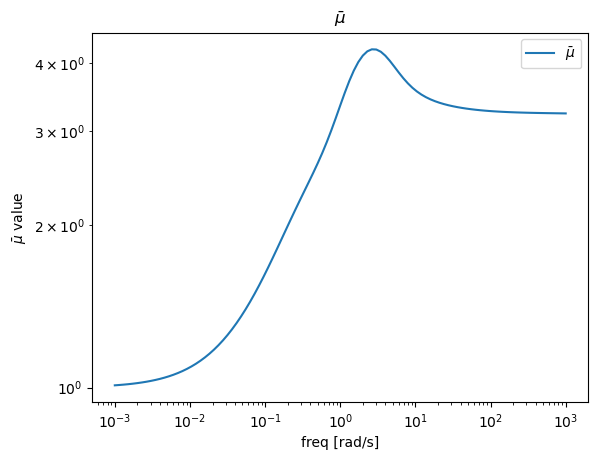

In [8]:
plt.loglog(omega, mubound, label=r'$\bar \mu$')
plt.ylabel(r'$\bar\mu$ value')
plt.xlabel('freq [rad/s]')
plt.legend()
plt.title(r'$\bar\mu$')